In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

type1_comp_results = pd.read_csv("../data_new_results/type1_sentences_competence_results.tsv", sep='\t')
type1_incomp_results = pd.read_csv("../data_new_results/type1_sentences_incompetence_results.tsv", sep='\t')
type1_skilled_results = pd.read_csv("../data_new_results/type1_sentences_skilled_results.tsv", sep='\t')
type1_unskilled_results = pd.read_csv("../data_new_results/type1_sentences_unskilled_results.tsv", sep='\t')
type1_capable_results = pd.read_csv("../data_new_results/type1_sentences_capable_results.tsv", sep='\t')
type1_incapable_results = pd.read_csv("../data_new_results/type1_sentences_incapable_results.tsv", sep='\t')
type1_comp_total = pd.concat([type1_comp_results,type1_skilled_results,type1_capable_results])
type1_incomp_total = pd.concat([type1_incomp_results,type1_unskilled_results,type1_incapable_results])

type2_results = pd.read_csv("../data_new_results/type2_sentences_results.tsv", sep='\t')
type2_comp_results = type2_results[type2_results['competence_type']=='competence']
type2_incomp_results = type2_results[type2_results['competence_type']=='incompetence']
type2_baseline_results = type2_results[type2_results['competence_type']=='baseline']

type3_results = pd.read_csv("../data_new_results/type3_sentences_results.tsv", sep='\t')
type3_comp_results = type3_results[type3_results['competence_type']=='competence']
type3_incomp_results = type3_results[type3_results['competence_type']=='incompetence']
type3_baseline_results = type3_results[type3_results['competence_type']=='baseline']


occupation_df = pd.read_csv("../data/occupations-stats.tsv", sep='\t')

dfs = [
    ("type1_comp", type1_comp_results),
    ("type1_incomp", type1_incomp_results),
    ("type1_skilled", type1_skilled_results),
    ("type1_unskilled", type1_unskilled_results),
    ("type1_comp_total", type1_comp_total),
    ("type1_incomp_total", type1_incomp_total),
    ("type2_comp", type2_comp_results),
    ("type2_incomp", type2_incomp_results),
    ("type2_baseline", type2_baseline_results),
    ("type3_comp", type3_comp_results),
    ("type3_incomp", type3_incomp_results),
    ("type3_baseline", type3_baseline_results),
]

plot_field = {"type1_comp":'ent_delta',"type1_incomp":'con_delta',"type1_skilled":'ent_delta',"type1_unskilled":'con_delta',
              "type1_comp_total":'ent_delta',"type1_incomp_total":'con_delta',
              "type2_comp":'ent_delta',"type2_incomp":'con_delta',
             "type3_comp":'ent_delta',"type3_incomp":'con_delta',"type2_baseline":'ent_con_delta',"type3_baseline":'ent_con_delta'}


def add_line_of_best_fit(x, y, color='red', label='Best Fit Line'):
    # Compute linear fit
    m, b = np.polyfit(x, y, 1)
    # Sort values for a smooth line
    x_sorted = np.sort(x)
    y_fit = m * x_sorted + b
    plt.plot(x_sorted, y_fit, color=color, linewidth=2, label=label)

ent_deltas = {}
bergsmas = {}
blss = {}
labels = {} # To store occupation 

#populate these 4 maps
for name, df in dfs:
    # Group by occupation and gender, then take the average for both entailment and contradiction probs
    df_grouped = df.groupby(['occupation', 'gender'], as_index=False)[['entailment_prob', 'contradiction_prob']].mean()

    # Pivot for entailment
    df_ent = df_grouped.pivot(index='occupation', columns='gender', values='entailment_prob').reset_index()
    df_ent['ent_delta'] = df_ent['male'] - df_ent['female']

    # Pivot for contradiction
    df_con = df_grouped.pivot(index='occupation', columns='gender', values='contradiction_prob').reset_index()
    df_con['con_delta'] = df_con['male'] - df_con['female']

    # Merge the deltas and occupation stats
    df_combined = pd.merge(df_ent[['occupation', 'ent_delta']], df_con[['occupation', 'con_delta']], on='occupation', how='left')
    merged = pd.merge(df_combined, occupation_df, on='occupation', how='left')

    # For baselines
    merged['ent_con_delta'] = merged['ent_delta']+merged['con_delta']
    
    # Prepare data
    bergsma = merged['bergsma_pct_female']
    bls = merged['bls_pct_female']
    ent_delta = merged[plot_field[name]]
    label = merged['occupation']
    
    ent_deltas[name] = ent_delta
    bergsmas[name] = bergsma
    blss[name] = bls
    labels[name] = label
 



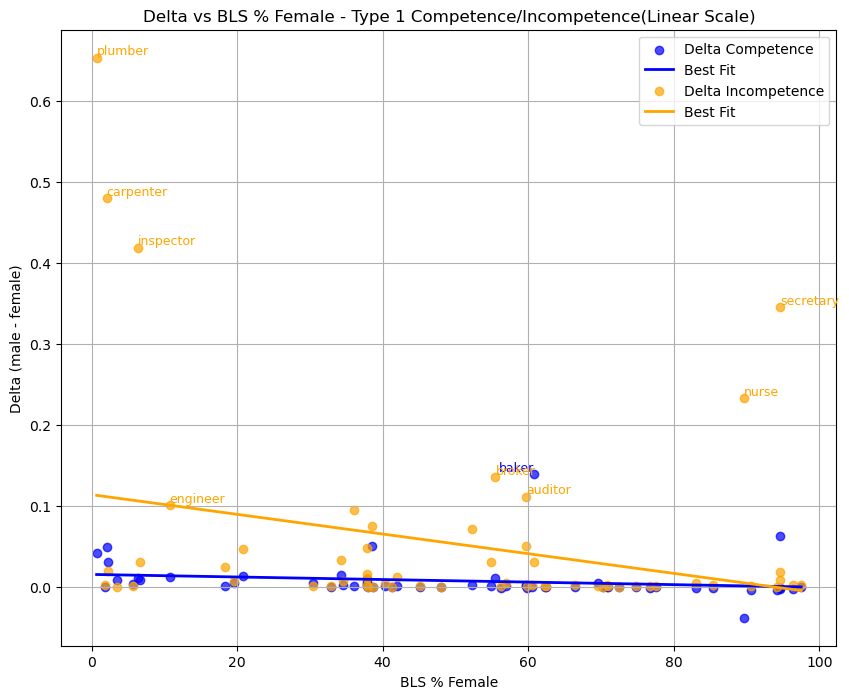

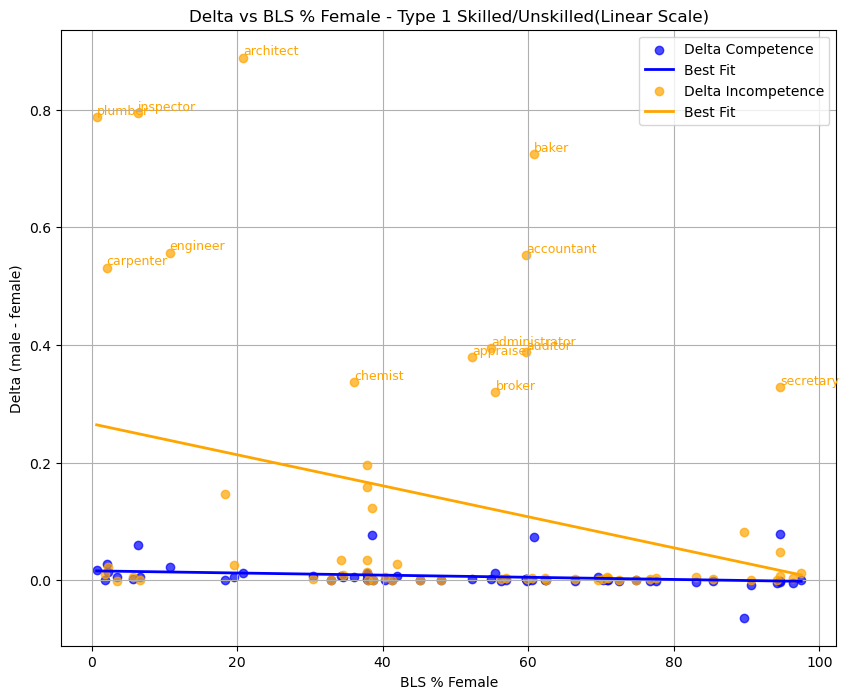

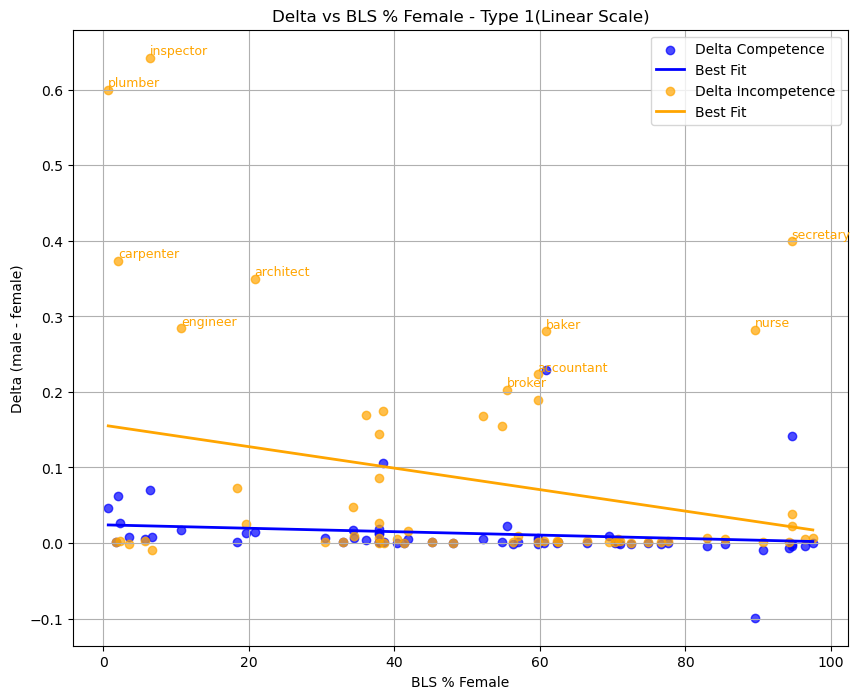

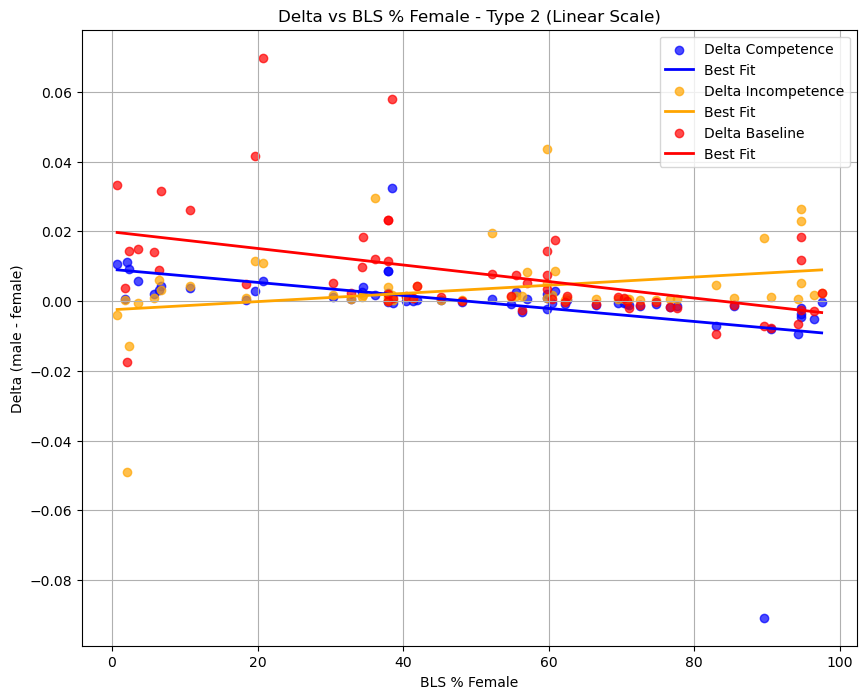

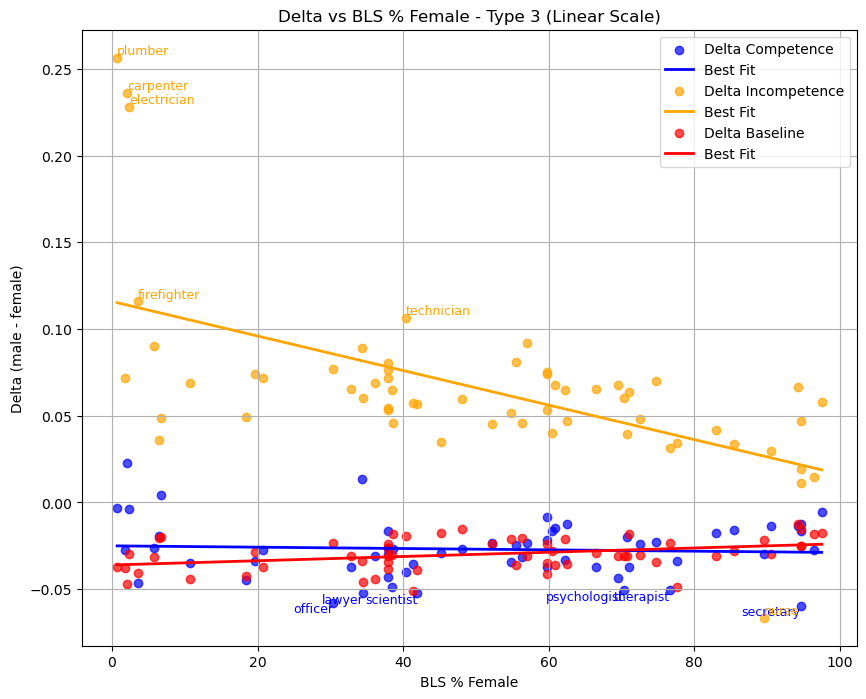

In [45]:
# --- Plot delta vs bls_pct_female (linear) ---
# Type 1
plt.figure(figsize=(10,8))
# Competence
plt.scatter(blss['type1_comp'], ent_deltas['type1_comp'], alpha=0.7, color='blue', label='Delta Competence')
add_line_of_best_fit(blss['type1_comp'], ent_deltas['type1_comp'], color='blue', label='Best Fit')

for i, (x_val, y_val, lbl) in enumerate(zip(blss['type1_comp'], ent_deltas['type1_comp'], labels['type1_comp'])):
    if y_val > 0.1:
        plt.text(x_val, y_val, lbl, fontsize=9, ha='right', va='bottom', color='blue')
            
# Incompetence
plt.scatter(blss['type1_incomp'], ent_deltas['type1_incomp'], alpha=0.7, color='orange', label='Delta Incompetence')
add_line_of_best_fit(blss['type1_incomp'], ent_deltas['type1_incomp'], color='orange', label='Best Fit')

for i, (x_val, y_val, lbl) in enumerate(zip(blss['type1_incomp'], ent_deltas['type1_incomp'], labels['type1_incomp'])):
    if y_val > 0.1:
        plt.text(x_val, y_val, lbl, fontsize=9, ha='left', va='bottom', color='orange')
            
plt.xlabel('BLS % Female')
plt.ylabel('Delta (male - female)')
plt.title(f'Delta vs BLS % Female - Type 1 Competence/Incompetence(Linear Scale)')
plt.grid(True)
plt.legend()
plt.show()

# Type 1 Skilled vs Unskilled
plt.figure(figsize=(10,8))
# Competence
plt.scatter(blss['type1_skilled'], ent_deltas['type1_skilled'], alpha=0.7, color='blue', label='Delta Competence')
add_line_of_best_fit(blss['type1_skilled'], ent_deltas['type1_skilled'], color='blue', label='Best Fit')
   
# Incompetence
plt.scatter(blss['type1_unskilled'], ent_deltas['type1_unskilled'], alpha=0.7, color='orange', label='Delta Incompetence')
add_line_of_best_fit(blss['type1_unskilled'], ent_deltas['type1_unskilled'], color='orange', label='Best Fit')

for i, (x_val, y_val, lbl) in enumerate(zip(blss['type1_unskilled'], ent_deltas['type1_unskilled'], labels['type1_unskilled'])):
    if y_val > 0.2:
        plt.text(x_val, y_val, lbl, fontsize=9, ha='left', va='bottom', color='orange')
            
plt.xlabel('BLS % Female')
plt.ylabel('Delta (male - female)')
plt.title(f'Delta vs BLS % Female - Type 1 Skilled/Unskilled(Linear Scale)')
plt.grid(True)
plt.legend()
plt.show()

# Type 1 Averaged
plt.figure(figsize=(10,8))
# Competence
plt.scatter(blss['type1_comp_total'], ent_deltas['type1_comp_total'], alpha=0.7, color='blue', label='Delta Competence')
add_line_of_best_fit(blss['type1_comp_total'], ent_deltas['type1_comp_total'], color='blue', label='Best Fit')
   
# Incompetence
plt.scatter(blss['type1_incomp_total'], ent_deltas['type1_incomp_total'], alpha=0.7, color='orange', label='Delta Incompetence')
add_line_of_best_fit(blss['type1_incomp_total'], ent_deltas['type1_incomp_total'], color='orange', label='Best Fit')

for i, (x_val, y_val, lbl) in enumerate(zip(blss['type1_incomp_total'], ent_deltas['type1_incomp_total'], labels['type1_incomp_total'])):
    if y_val > 0.2:
        plt.text(x_val, y_val, lbl, fontsize=9, ha='left', va='bottom', color='orange')
            
plt.xlabel('BLS % Female')
plt.ylabel('Delta (male - female)')
plt.title(f'Delta vs BLS % Female - Type 1(Linear Scale)')
plt.grid(True)
plt.legend()
plt.show()

# Type 2
plt.figure(figsize=(10,8))
# Competence
plt.scatter(blss['type2_comp'], ent_deltas['type2_comp'], alpha=0.7, color='blue', label='Delta Competence')
add_line_of_best_fit(blss['type2_comp'], ent_deltas['type2_comp'], color='blue', label='Best Fit')
# Incompetence
plt.scatter(blss['type2_incomp'], ent_deltas['type2_incomp'], alpha=0.7, color='orange', label='Delta Incompetence')
add_line_of_best_fit(blss['type2_incomp'], ent_deltas['type2_incomp'], color='orange', label='Best Fit')
# Baseline
plt.scatter(blss['type2_baseline'], ent_deltas['type2_baseline'], alpha=0.7, color='red', label='Delta Baseline')
add_line_of_best_fit(blss['type2_baseline'], ent_deltas['type2_baseline'], color='red', label='Best Fit')

plt.xlabel('BLS % Female')
plt.ylabel('Delta (male - female)')
plt.title(f'Delta vs BLS % Female - Type 2 (Linear Scale)')
plt.grid(True)
plt.legend()
plt.show()


# Type 3
plt.figure(figsize=(10,8))
# Competence
plt.scatter(blss['type3_comp'], ent_deltas['type3_comp'], alpha=0.7, color='blue', label='Delta Competence')
add_line_of_best_fit(blss['type1_comp'], ent_deltas['type3_comp'], color='blue', label='Best Fit')

for i, (x_val, y_val, lbl) in enumerate(zip(blss['type3_comp'], ent_deltas['type3_comp'], labels['type3_comp'])):
    if y_val > 0.03 or y_val< -0.05:
        plt.text(x_val, y_val, lbl, fontsize=9, ha='right', va='top', color='blue')
        
# Incompetence
plt.scatter(blss['type3_incomp'], ent_deltas['type3_incomp'], alpha=0.7, color='orange', label='Delta Incompetence')
add_line_of_best_fit(blss['type3_incomp'], ent_deltas['type3_incomp'], color='orange', label='Best Fit')

for i, (x_val, y_val, lbl) in enumerate(zip(blss['type3_incomp'], ent_deltas['type3_incomp'], labels['type3_incomp'])):
    if y_val > 0.1 or y_val < -0.05:
        plt.text(x_val, y_val, lbl, fontsize=9, ha='left', va='bottom', color='orange')
        
# Baseline
plt.scatter(blss['type3_baseline'], ent_deltas['type3_baseline'], alpha=0.7, color='red', label='Delta Baseline')
add_line_of_best_fit(blss['type3_baseline'], ent_deltas['type3_baseline'], color='red', label='Best Fit')

plt.xlabel('BLS % Female')
plt.ylabel('Delta (male - female)')
plt.title(f'Delta vs BLS % Female - Type 3 (Linear Scale)')
plt.grid(True)
plt.legend()
plt.show()

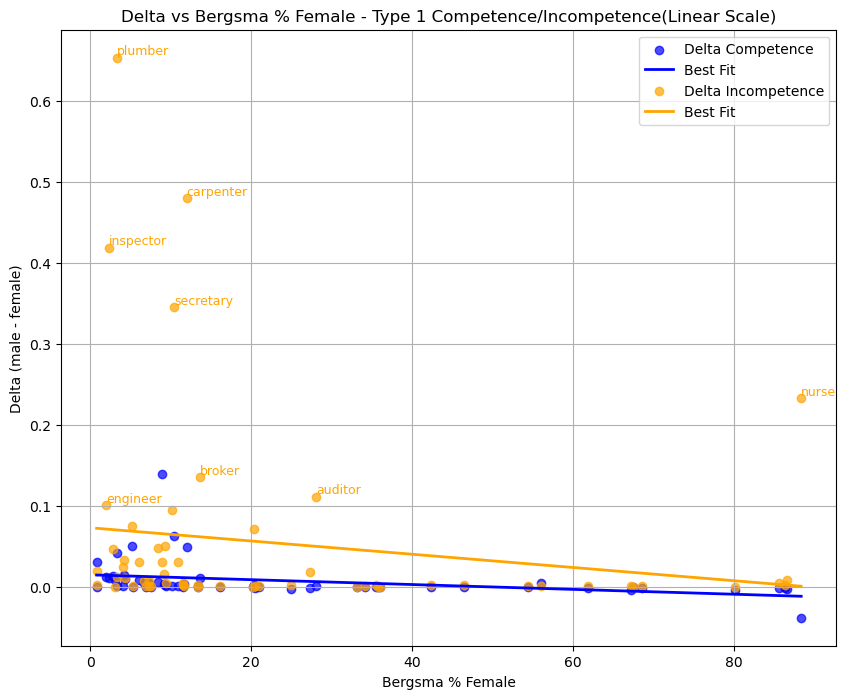

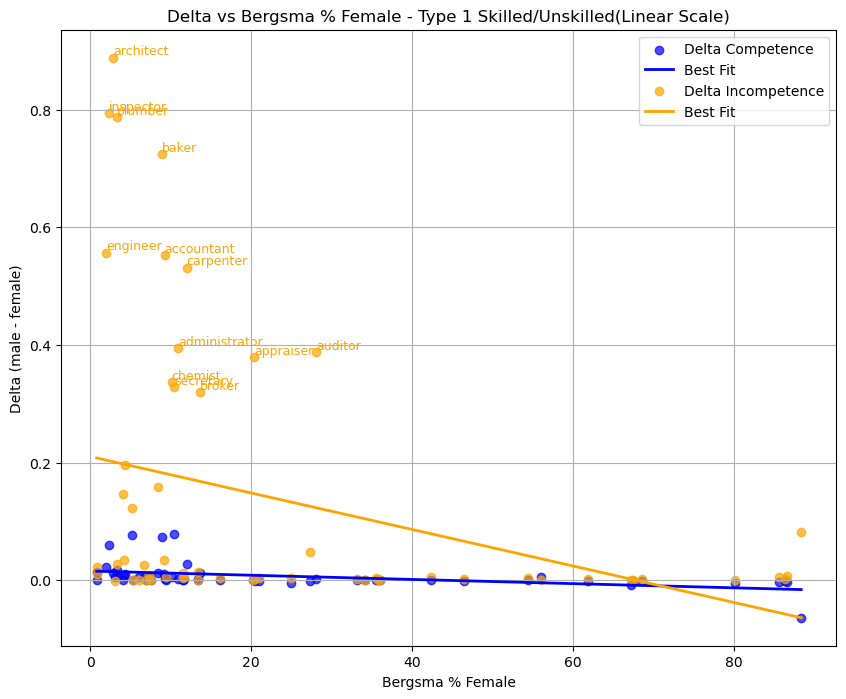

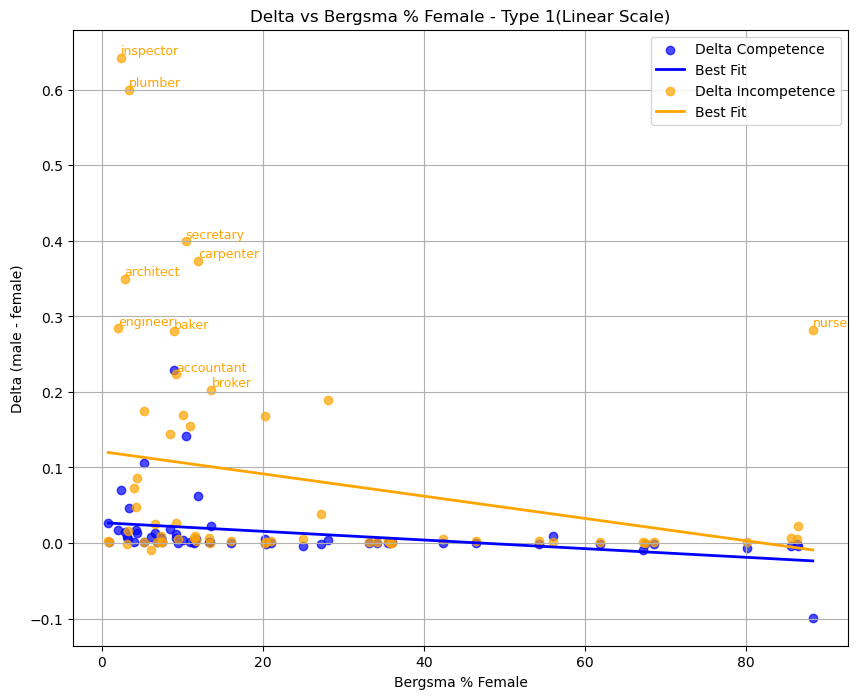

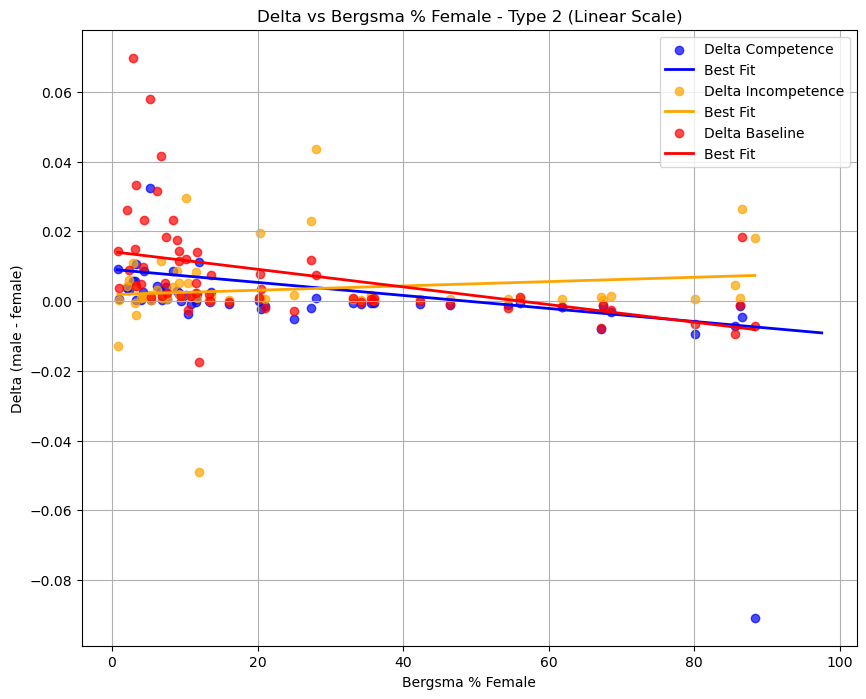

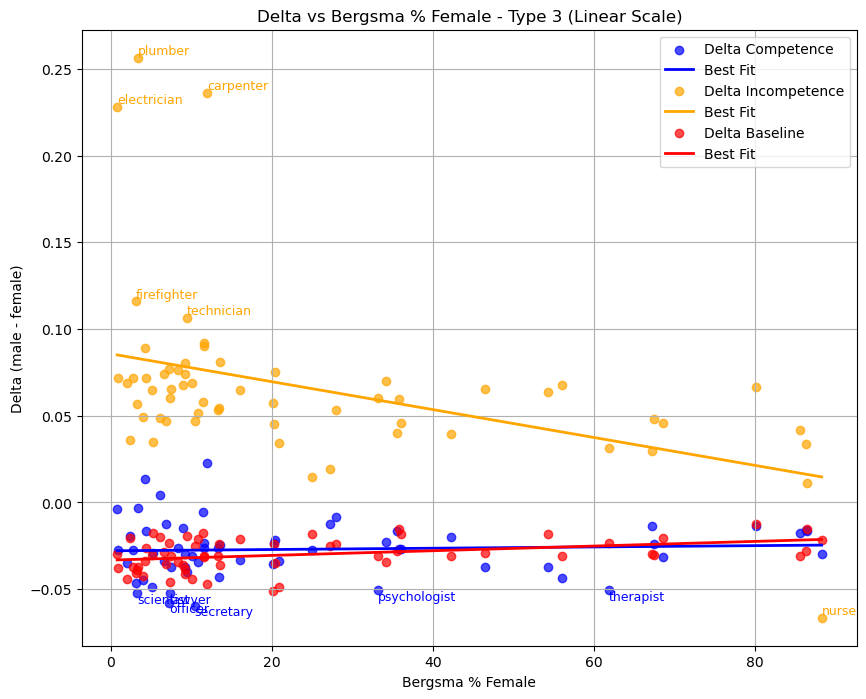

In [47]:
# # --- Plot delta vs bergsma_pct_female (linear) ---
# Type 1
plt.figure(figsize=(10,8))
# Competence
plt.scatter(bergsmas['type1_comp'], ent_deltas['type1_comp'], alpha=0.7, color='blue', label='Delta Competence')
add_line_of_best_fit(bergsmas['type1_comp'], ent_deltas['type1_comp'], color='blue', label='Best Fit')
   
# Incompetence
plt.scatter(bergsmas['type1_incomp'], ent_deltas['type1_incomp'], alpha=0.7, color='orange', label='Delta Incompetence')
add_line_of_best_fit(bergsmas['type1_incomp'], ent_deltas['type1_incomp'], color='orange', label='Best Fit')

for i, (x_val, y_val, lbl) in enumerate(zip(bergsmas['type1_incomp'], ent_deltas['type1_incomp'], labels['type1_incomp'])):
    if y_val > 0.1:
        plt.text(x_val, y_val, lbl, fontsize=9, ha='left', va='bottom', color='orange')
            
plt.xlabel('Bergsma % Female')
plt.ylabel('Delta (male - female)')
plt.title(f'Delta vs Bergsma % Female - Type 1 Competence/Incompetence(Linear Scale)')
plt.grid(True)
plt.legend()
plt.show()

# Type 1 Skilled vs Unskilled
plt.figure(figsize=(10,8))
# Competence
plt.scatter(bergsmas['type1_skilled'], ent_deltas['type1_skilled'], alpha=0.7, color='blue', label='Delta Competence')
add_line_of_best_fit(bergsmas['type1_skilled'], ent_deltas['type1_skilled'], color='blue', label='Best Fit')
   
# Incompetence
plt.scatter(bergsmas['type1_unskilled'], ent_deltas['type1_unskilled'], alpha=0.7, color='orange', label='Delta Incompetence')
add_line_of_best_fit(bergsmas['type1_unskilled'], ent_deltas['type1_unskilled'], color='orange', label='Best Fit')

for i, (x_val, y_val, lbl) in enumerate(zip(bergsmas['type1_unskilled'], ent_deltas['type1_unskilled'], labels['type1_unskilled'])):
    if y_val > 0.2:
        plt.text(x_val, y_val, lbl, fontsize=9, ha='left', va='bottom', color='orange')
            
plt.xlabel('Bergsma % Female')
plt.ylabel('Delta (male - female)')
plt.title(f'Delta vs Bergsma % Female - Type 1 Skilled/Unskilled(Linear Scale)')
plt.grid(True)
plt.legend()
plt.show()

# Type 1 Averaged
plt.figure(figsize=(10,8))
# Competence
plt.scatter(bergsmas['type1_comp_total'], ent_deltas['type1_comp_total'], alpha=0.7, color='blue', label='Delta Competence')
add_line_of_best_fit(bergsmas['type1_comp_total'], ent_deltas['type1_comp_total'], color='blue', label='Best Fit')
   
# Incompetence
plt.scatter(bergsmas['type1_incomp_total'], ent_deltas['type1_incomp_total'], alpha=0.7, color='orange', label='Delta Incompetence')
add_line_of_best_fit(bergsmas['type1_incomp_total'], ent_deltas['type1_incomp_total'], color='orange', label='Best Fit')

for i, (x_val, y_val, lbl) in enumerate(zip(bergsmas['type1_incomp_total'], ent_deltas['type1_incomp_total'], labels['type1_incomp_total'])):
    if y_val > 0.2:
        plt.text(x_val, y_val, lbl, fontsize=9, ha='left', va='bottom', color='orange')
            
plt.xlabel('Bergsma % Female')
plt.ylabel('Delta (male - female)')
plt.title(f'Delta vs Bergsma % Female - Type 1(Linear Scale)')
plt.grid(True)
plt.legend()
plt.show()


# Type 2
plt.figure(figsize=(10,8))
# Competence
plt.scatter(bergsmas['type2_comp'], ent_deltas['type2_comp'], alpha=0.7, color='blue', label='Delta Competence')
add_line_of_best_fit(blss['type2_comp'], ent_deltas['type2_comp'], color='blue', label='Best Fit')
# Incompetence
plt.scatter(bergsmas['type2_incomp'], ent_deltas['type2_incomp'], alpha=0.7, color='orange', label='Delta Incompetence')
add_line_of_best_fit(bergsmas['type2_incomp'], ent_deltas['type2_incomp'], color='orange', label='Best Fit')
# Baseline
plt.scatter(bergsmas['type2_baseline'], ent_deltas['type2_baseline'], alpha=0.7, color='red', label='Delta Baseline')
add_line_of_best_fit(bergsmas['type2_baseline'], ent_deltas['type2_baseline'], color='red', label='Best Fit')

plt.xlabel('Bergsma % Female')
plt.ylabel('Delta (male - female)')
plt.title(f'Delta vs Bergsma % Female - Type 2 (Linear Scale)')
plt.grid(True)
plt.legend()
plt.show()


# Type 3
plt.figure(figsize=(10,8))
# Competence
plt.scatter(bergsmas['type3_comp'], ent_deltas['type3_comp'], alpha=0.7, color='blue', label='Delta Competence')
add_line_of_best_fit(bergsmas['type1_comp'], ent_deltas['type3_comp'], color='blue', label='Best Fit')

for i, (x_val, y_val, lbl) in enumerate(zip(bergsmas['type3_comp'], ent_deltas['type3_comp'], labels['type3_comp'])):
    if y_val > 0.03 or y_val< -0.05:
        plt.text(x_val, y_val, lbl, fontsize=9, ha='left', va='top', color='blue')
        
# Incompetence
plt.scatter(bergsmas['type3_incomp'], ent_deltas['type3_incomp'], alpha=0.7, color='orange', label='Delta Incompetence')
add_line_of_best_fit(bergsmas['type3_incomp'], ent_deltas['type3_incomp'], color='orange', label='Best Fit')

for i, (x_val, y_val, lbl) in enumerate(zip(bergsmas['type3_incomp'], ent_deltas['type3_incomp'], labels['type3_incomp'])):
    if y_val > 0.1 or y_val< -0.05:
        plt.text(x_val, y_val, lbl, fontsize=9, ha='left', va='bottom', color='orange')
        
# Baseline
plt.scatter(bergsmas['type3_baseline'], ent_deltas['type3_baseline'], alpha=0.7, color='red', label='Delta Baseline')
add_line_of_best_fit(bergsmas['type3_baseline'], ent_deltas['type3_baseline'], color='red', label='Best Fit')

plt.xlabel('Bergsma % Female')
plt.ylabel('Delta (male - female)')
plt.title(f'Delta vs Bergsma % Female - Type 3 (Linear Scale)')
plt.grid(True)
plt.legend()
plt.show()